In [146]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import Tokenizer,StopWordsRemover
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import IDF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator,ParamGridBuilder
import numpy as np
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import NaiveBayes
from pyspark.sql import SQLContext
import pyspark as ps
from pyspark.ml.classification import LinearSVC
import warnings
from nltk.stem.snowball import SnowballStemmer
import pandas
import matplotlib.pyplot as plt
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
import pandas as pd

In [2]:
try:
    sc = ps.SparkContext('local[*]')
    sqlContext = SQLContext(sc)
    print("Just created a SparkContext")
except ValueError:
    warnings.warn("SparkContext already exists in this scope")

c:\python36\lib\site-packages\ipykernel_launcher.py:6: UserWarning: SparkContext already exists in this scope
  


In [3]:
spark=SparkSession.builder.getOrCreate()

In [4]:
df=spark.read.csv("twitter.csv",sep=",",inferSchema=True,header=False)

In [5]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- _c1: integer (nullable = true)
 |-- _c2: string (nullable = true)



In [6]:
df.show(truncate=False)
#df.show()

+---+---+-------------------------------------------------------------------------------------------------------------------------------------------+
|_c0|_c1|_c2                                                                                                                                        |
+---+---+-------------------------------------------------------------------------------------------------------------------------------------------+
|1  |1  | @user when a father is disfunctional and is so selfish he drags his kids into his disfunction.   #run                                     |
|2  |0  |@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked                 |
|3  |1  |@user that was fucking weird                                                                                                               |
|4  |1  |@userthat was so shitty                                                                    

In [7]:
df.count()

31962

In [8]:
df1=df.withColumnRenamed('_c0',"id").withColumnRenamed('_c1','label').withColumnRenamed('_c2','tweet')

In [9]:
df1.printSchema()

root
 |-- id: integer (nullable = true)
 |-- label: integer (nullable = true)
 |-- tweet: string (nullable = true)



In [10]:
df1.show(truncate=False)

+---+-----+-------------------------------------------------------------------------------------------------------------------------------------------+
|id |label|tweet                                                                                                                                      |
+---+-----+-------------------------------------------------------------------------------------------------------------------------------------------+
|1  |1    | @user when a father is disfunctional and is so selfish he drags his kids into his disfunction.   #run                                     |
|2  |0    |@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked                 |
|3  |1    |@user that was fucking weird                                                                                                               |
|4  |1    |@userthat was so shitty                                                      

In [11]:
df2 = df1.withColumn('tweet', regexp_replace('tweet', '[^a-z0-9A-Z`~!@#$%&<>?., ]', ''))

In [12]:
df2.show(truncate=False)

+---+-----+--------------------------------------------------------------------------------------------------------------------------------------+
|id |label|tweet                                                                                                                                 |
+---+-----+--------------------------------------------------------------------------------------------------------------------------------------+
|1  |1    | @user when a father is disfunctional and is so selfish he drags his kids into his disfunction.   #run                                |
|2  |0    |@user @user thanks for #lyft credit i cant use cause they dont offer wheelchair vans in pdx.    #disapointed #getthanked              |
|3  |1    |@user that was fucking weird                                                                                                          |
|4  |1    |@userthat was so shitty                                                                                    

In [13]:
df3 = df2.withColumn('tweet', regexp_replace('tweet', '[0-9`~!@#$%&<>?,\']', ''))

In [14]:
df3.show(truncate=False)

+---+-----+-------------------------------------------------------------------------------------------------------------------------------+
|id |label|tweet                                                                                                                          |
+---+-----+-------------------------------------------------------------------------------------------------------------------------------+
|1  |1    | user when a father is disfunctional and is so selfish he drags his kids into his disfunction.   run                           |
|2  |0    |user user thanks for lyft credit i cant use cause they dont offer wheelchair vans in pdx.    disapointed getthanked            |
|3  |1    |user that was fucking weird                                                                                                    |
|4  |1    |userthat was so shitty                                                                                                         |
|5  |0    | factsgui

In [15]:
df4 = df3.withColumn('tweet', regexp_replace('tweet', 'http://*.*.com', ''))

In [16]:
df4.show(truncate=False)

+---+-----+-------------------------------------------------------------------------------------------------------------------------------+
|id |label|tweet                                                                                                                          |
+---+-----+-------------------------------------------------------------------------------------------------------------------------------+
|1  |1    | user when a father is disfunctional and is so selfish he drags his kids into his disfunction.   run                           |
|2  |0    |user user thanks for lyft credit i cant use cause they dont offer wheelchair vans in pdx.    disapointed getthanked            |
|3  |1    |user that was fucking weird                                                                                                    |
|4  |1    |userthat was so shitty                                                                                                         |
|5  |0    | factsgui

In [17]:
df5 = df4.withColumn('tweet', regexp_replace('tweet', 'www.*.com', ''))

In [18]:
df5.show(truncate=False)

+---+-----+-------------------------------------------------------------------------------------------------------------------------------+
|id |label|tweet                                                                                                                          |
+---+-----+-------------------------------------------------------------------------------------------------------------------------------+
|1  |1    | user when a father is disfunctional and is so selfish he drags his kids into his disfunction.   run                           |
|2  |0    |user user thanks for lyft credit i cant use cause they dont offer wheelchair vans in pdx.    disapointed getthanked            |
|3  |1    |user that was fucking weird                                                                                                    |
|4  |1    |userthat was so shitty                                                                                                         |
|5  |0    | factsgui

In [19]:
df6 = df5.withColumn('tweet', regexp_replace('tweet', '\.', ''))

In [20]:
df6.show(truncate=False)

+---+-----+------------------------------------------------------------------------------------------------------------------------------+
|id |label|tweet                                                                                                                         |
+---+-----+------------------------------------------------------------------------------------------------------------------------------+
|1  |1    | user when a father is disfunctional and is so selfish he drags his kids into his disfunction   run                           |
|2  |0    |user user thanks for lyft credit i cant use cause they dont offer wheelchair vans in pdx    disapointed getthanked            |
|3  |1    |user that was fucking weird                                                                                                   |
|4  |1    |userthat was so shitty                                                                                                        |
|5  |0    | factsguide soci

In [21]:
tokenizer=Tokenizer(inputCol="tweet",outputCol="words")
wordData=tokenizer.transform(df6)

In [22]:
wordData.show()

+---+-----+--------------------+--------------------+
| id|label|               tweet|               words|
+---+-----+--------------------+--------------------+
|  1|    1| user when a fath...|[, user, when, a,...|
|  2|    0|user user thanks ...|[user, user, than...|
|  3|    1|user that was fuc...|[user, that, was,...|
|  4|    1|userthat was so s...|[userthat, was, s...|
|  5|    0| factsguide socie...|[, factsguide, so...|
|  6|    0| huge fan fare an...|[, huge, fan, far...|
|  7|    0| user camping tom...|[, user, camping,...|
|  8|    0|the next school y...|[the, next, schoo...|
|  9|    0|we won love the l...|[we, won, love, t...|
| 10|    1|   you are so boring|[, you, are, so, ...|
| 11|    0|  ireland consume...|[, , ireland, con...|
| 12|    0|we are so selfish...|[we, are, so, sel...|
| 13|    0|i get to see my d...|[i, get, to, see,...|
| 14|    1|  i wont spare you  |[i, wont, spare, ...|
| 15|    1|it was not good f...|[it, was, not, go...|
| 16|    1|ouchjunior is ang

In [23]:
remover=StopWordsRemover(inputCol="words",outputCol="word_clean")
word_clean_data=remover.transform(wordData)

In [24]:
word_clean_data.show()

+---+-----+--------------------+--------------------+--------------------+
| id|label|               tweet|               words|          word_clean|
+---+-----+--------------------+--------------------+--------------------+
|  1|    1| user when a fath...|[, user, when, a,...|[, user, father, ...|
|  2|    0|user user thanks ...|[user, user, than...|[user, user, than...|
|  3|    1|user that was fuc...|[user, that, was,...|[user, fucking, w...|
|  4|    1|userthat was so s...|[userthat, was, s...|  [userthat, shitty]|
|  5|    0| factsguide socie...|[, factsguide, so...|[, factsguide, so...|
|  6|    0| huge fan fare an...|[, huge, fan, far...|[, huge, fan, far...|
|  7|    0| user camping tom...|[, user, camping,...|[, user, camping,...|
|  8|    0|the next school y...|[the, next, schoo...|[next, school, ye...|
|  9|    0|we won love the l...|[we, won, love, t...|[won, love, land,...|
| 10|    1|   you are so boring|[, you, are, so, ...|          [, boring]|
| 11|    0|  ireland cons

In [25]:
stemmer = SnowballStemmer(language='english')

In [26]:
stemmer_udf = udf(lambda tokens: [stemmer.stem(token) for token in tokens])

In [27]:
count=CountVectorizer(inputCol="word_clean",outputCol="rawFeatures")
print(count)

CountVectorizer_4b9eb8d221f2


In [28]:
model=count.fit(word_clean_data)
print(model)

CountVectorizer_4b9eb8d221f2


In [29]:
featurizedData=model.transform(word_clean_data)

In [30]:
featurizedData.show()

+---+-----+--------------------+--------------------+--------------------+--------------------+
| id|label|               tweet|               words|          word_clean|         rawFeatures|
+---+-----+--------------------+--------------------+--------------------+--------------------+
|  1|    1| user when a fath...|[, user, when, a,...|[, user, father, ...|(39572,[0,1,161,1...|
|  2|    0|user user thanks ...|[user, user, than...|[user, user, than...|(39572,[0,1,19,22...|
|  3|    1|user that was fuc...|[user, that, was,...|[user, fucking, w...|(39572,[1,525,126...|
|  4|    1|userthat was so s...|[userthat, was, s...|  [userthat, shitty]|(39572,[2934,3100...|
|  5|    0| factsguide socie...|[, factsguide, so...|[, factsguide, so...|(39572,[0,195,149...|
|  6|    0| huge fan fare an...|[, huge, fan, far...|[, huge, fan, far...|(39572,[0,15,107,...|
|  7|    0| user camping tom...|[, user, camping,...|[, user, camping,...|(39572,[0,1,57,19...|
|  8|    0|the next school y...|[the, ne

In [31]:
idf=IDF(inputCol="rawFeatures",outputCol="features")

In [32]:
idfModel=idf.fit(featurizedData)

In [33]:
rescaledData=idfModel.transform(featurizedData)

In [34]:
rescaledData.select("label","features").show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    1|(39572,[0,1,161,1...|
|    0|(39572,[0,1,19,22...|
|    1|(39572,[1,525,126...|
|    1|(39572,[2934,3100...|
|    0|(39572,[0,195,149...|
|    0|(39572,[0,15,107,...|
|    0|(39572,[0,1,57,19...|
|    0|(39572,[0,19,63,7...|
|    0|(39572,[2,747,983...|
|    1|(39572,[0,1979],[...|
|    0|(39572,[0,66,88,9...|
|    0|(39572,[0,2,61,68...|
|    0|(39572,[0,11,15,2...|
|    1|(39572,[268,5830]...|
|    1|(39572,[18],[3.66...|
|    1|(39572,[0,308,436...|
|    0|(39572,[13,14,164...|
|    1|(39572,[335,787],...|
|    0|(39572,[0,1,16,33...|
|    0|(39572,[55,138,17...|
+-----+--------------------+
only showing top 20 rows



In [35]:
seed=0
trainDf,testDf=rescaledData.randomSplit([0.7,0.3],seed)

In [36]:
trainDf.count()

22457

In [37]:
testDf.count()

9505

In [38]:
# Logistsic Regression implementation

In [39]:
lr=LogisticRegression(maxIter=15)

In [40]:
paramGrid_lr=ParamGridBuilder().build()# some part is remaining to add

In [41]:
crossval_lr=CrossValidator(estimator=lr,estimatorParamMaps=paramGrid_lr,evaluator=BinaryClassificationEvaluator(),numFolds=8)

In [42]:
cvModel_lr=crossval_lr.fit(trainDf)

In [43]:
best_model_lr=cvModel_lr.bestModel.summary

In [44]:
roc = best_model_lr.roc.toPandas()

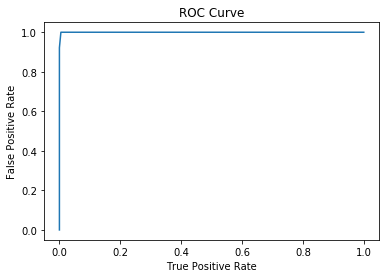

In [45]:
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [46]:
report=BinaryClassificationEvaluator(rawPredictionCol="prediction",labelCol="label",metricName="areaUnderROC")

In [47]:
report.evaluate(best_model_lr.predictions)

0.9983836868244412

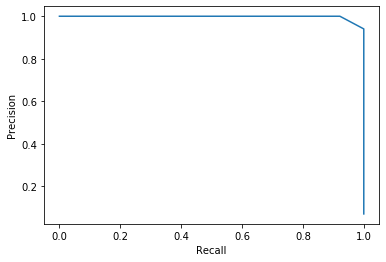

In [48]:
pr = best_model_lr.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [49]:
pred_lr=MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="label",metricName="f1")

In [50]:
pred_lr.evaluate(best_model_lr.predictions)

0.9996881575865108

In [51]:
pred_lr=MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="label",metricName="accuracy")

In [52]:
pred_lr.evaluate(best_model_lr.predictions)

0.9996882931825266

In [53]:
train_fit_lr=best_model_lr.predictions.select('label','prediction')

In [54]:
train_fit_lr.groupBy('label','prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 1589|
|  0.0|       1.0|    2|
|  1.0|       0.0|    5|
|  0.0|       0.0|20861|
+-----+----------+-----+



In [63]:
testDf.show(5)

+---+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
| id|label|               tweet|               words|          word_clean|         rawFeatures|            features|
+---+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|  1|    1| user when a fath...|[, user, when, a,...|[, user, father, ...|(39572,[0,1,161,1...|(39572,[0,1,161,1...|
|  4|    1|userthat was so s...|[userthat, was, s...|  [userthat, shitty]|(39572,[2934,3100...|(39572,[2934,3100...|
|  5|    0| factsguide socie...|[, factsguide, so...|[, factsguide, so...|(39572,[0,195,149...|(39572,[0,195,149...|
|  6|    0| huge fan fare an...|[, huge, fan, far...|[, huge, fan, far...|(39572,[0,15,107,...|(39572,[0,15,107,...|
|  8|    0|the next school y...|[the, next, schoo...|[next, school, ye...|(39572,[0,19,63,7...|(39572,[0,19,63,7...|
+---+-----+--------------------+--------------------+-----------

In [55]:
predictions_lr=cvModel_lr.transform(testDf)

In [99]:
print(predictions_lr)

DataFrame[id: int, label: int, tweet: string, words: array<string>, word_clean: array<string>, rawFeatures: vector, features: vector, rawPrediction: vector, probability: vector, prediction: double]


In [56]:
predictions_lr.show(5)

+---+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
| id|label|               tweet|               words|          word_clean|         rawFeatures|            features|       rawPrediction|         probability|prediction|
+---+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|  1|    1| user when a fath...|[, user, when, a,...|[, user, father, ...|(39572,[0,1,161,1...|(39572,[0,1,161,1...|[14.3160126943883...|[0.99999939377419...|       0.0|
|  4|    1|userthat was so s...|[userthat, was, s...|  [userthat, shitty]|(39572,[2934,3100...|(39572,[2934,3100...|[-6.3304282171527...|[0.00177810355104...|       1.0|
|  5|    0| factsguide socie...|[, factsguide, so...|[, factsguide, so...|(39572,[0,195,149...|(39572,[0,195,149...|[13.9331862653385...|[0.9999991110

In [57]:
predictions_lr.select('label','prediction').show(5)

+-----+----------+
|label|prediction|
+-----+----------+
|    1|       0.0|
|    1|       1.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
+-----+----------+
only showing top 5 rows



In [108]:
predictions_lr.select('prediction').show(2)

+----------+
|prediction|
+----------+
|       0.0|
|       1.0|
+----------+
only showing top 2 rows



In [58]:
predictions_lr.groupBy('label','prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|  270|
|    0|       0.0| 8657|
|    1|       1.0|  385|
|    0|       1.0|  193|
+-----+----------+-----+



In [135]:
my_eval_lr = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='label', metricName='areaUnderROC')
my_eval_lr.evaluate(predictions_lr)

0.7829891749687324

In [60]:
my_mc_lr = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='accuracy')
my_mc_lr.evaluate(predictions_lr)

0.9512887953708574

In [61]:
my_mc_lr = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='f1')
my_mc_lr.evaluate(predictions_lr)

0.9498732996143916

In [ ]:
# user input(has to be implemented)

In [109]:
testdata=spark.read.csv("test.csv",sep=",",inferSchema=True,header=False)

In [110]:
testdata1=testdata.withColumnRenamed('_c0',"id").withColumnRenamed('_c1','label').withColumnRenamed('_c2','tweet')

In [111]:
testdata2 = testdata1.withColumn('tweet', regexp_replace('tweet', '[^a-z0-9A-Z`~!@#$%&<>?., ]', ''))

In [112]:
testdata3 = testdata2.withColumn('tweet', regexp_replace('tweet', '[0-9`~!@#$%&<>?,\']', ''))

In [113]:
testdata4 = testdata3.withColumn('tweet', regexp_replace('tweet', 'http://*.*.com', ''))

In [114]:
testdata5 = testdata4.withColumn('tweet', regexp_replace('tweet', 'www.*.com', ''))

In [115]:
testdata6 = testdata5.withColumn('tweet', regexp_replace('tweet', '\.', ''))

In [116]:
test_tokenizer=Tokenizer(inputCol="tweet",outputCol="words")
test_wordData=tokenizer.transform(testdata6)

In [117]:
test_wordData.show()

+---+-----+--------------+------------------+
| id|label|         tweet|             words|
+---+-----+--------------+------------------+
|  1|    1|happy new year|[happy, new, year]|
|  2|    0|   got to hell|   [got, to, hell]|
+---+-----+--------------+------------------+



In [118]:
test_remover=StopWordsRemover(inputCol="words",outputCol="word_clean")
test_word_clean_data=remover.transform(test_wordData)

In [119]:
test_word_clean_data.show()

+---+-----+--------------+------------------+------------------+
| id|label|         tweet|             words|        word_clean|
+---+-----+--------------+------------------+------------------+
|  1|    1|happy new year|[happy, new, year]|[happy, new, year]|
|  2|    0|   got to hell|   [got, to, hell]|       [got, hell]|
+---+-----+--------------+------------------+------------------+



In [120]:
count=CountVectorizer(inputCol="word_clean",outputCol="rawFeatures")
print(count)

CountVectorizer_4f5e139cc6c4


In [121]:
model=count.fit(test_word_clean_data)
print(model)

CountVectorizer_4f5e139cc6c4


In [140]:
featurizedData=model.transform(test_word_clean_data)

In [141]:
featurizedData.show()

+---+-----+--------------+------------------+------------------+--------------------+
| id|label|         tweet|             words|        word_clean|         rawFeatures|
+---+-----+--------------+------------------+------------------+--------------------+
|  1|    1|happy new year|[happy, new, year]|[happy, new, year]|(5,[2,3,4],[1.0,1...|
|  2|    0|   got to hell|   [got, to, hell]|       [got, hell]| (5,[0,1],[1.0,1.0])|
+---+-----+--------------+------------------+------------------+--------------------+



In [124]:
idf=IDF(inputCol="rawFeatures",outputCol="features")

In [125]:
idfModel=idf.fit(featurizedData)

In [126]:
rescaledData=idfModel.transform(featurizedData)

In [127]:
rescaledData.select("label","features").show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    1|(5,[2,3,4],[0.405...|
|    0|(5,[0,1],[0.40546...|
+-----+--------------------+



In [128]:
rescaledData.show()

+---+-----+--------------+------------------+------------------+--------------------+--------------------+
| id|label|         tweet|             words|        word_clean|         rawFeatures|            features|
+---+-----+--------------+------------------+------------------+--------------------+--------------------+
|  1|    1|happy new year|[happy, new, year]|[happy, new, year]|(5,[2,3,4],[1.0,1...|(5,[2,3,4],[0.405...|
|  2|    0|   got to hell|   [got, to, hell]|       [got, hell]| (5,[0,1],[1.0,1.0])|(5,[0,1],[0.40546...|
+---+-----+--------------+------------------+------------------+--------------------+--------------------+



In [149]:
#Naive bayes implementation
nb = NaiveBayes()

In [150]:
paramGrid_nb = ParamGridBuilder() \
    .addGrid(nb.smoothing, np.linspace(0.3, 10, 10)) \
    .build()

In [151]:
crossval_nb = CrossValidator(estimator=nb,
                          estimatorParamMaps=paramGrid_nb,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds= 5)

In [152]:
cvModel_nb = crossval_nb.fit(trainDf)

In [153]:
train_pred=cvModel_nb.transform(trainDf)

In [154]:
train_pred.groupBy('label','prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|   30|
|    0|       0.0|20446|
|    1|       1.0| 1564|
|    0|       1.0|  417|
+-----+----------+-----+



In [155]:
my_eval_nb = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='label', metricName='areaUnderROC')
my_eval_nb.evaluate(train_pred)

0.9805959425446922

In [156]:
my_mc_nb = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='f1')
my_mc_nb.evaluate(train_pred)

0.981079482732061

In [157]:
my_mc_nb = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='accuracy')
my_mc_nb.evaluate(train_pred)

0.9800952932270561

In [158]:
predictions_nb = cvModel_nb.transform(testDf)
predictions_nb.select('label', 'prediction').show(5)

+-----+----------+
|label|prediction|
+-----+----------+
|    1|       0.0|
|    1|       1.0|
|    0|       0.0|
|    0|       1.0|
|    0|       0.0|
+-----+----------+
only showing top 5 rows



In [159]:
predictions_nb.groupBy('label','prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|   84|
|    0|       0.0| 7216|
|    1|       1.0|  571|
|    0|       1.0| 1634|
+-----+----------+-----+



In [160]:
my_eval_nb = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='label', metricName='areaUnderROC')
my_eval_nb.evaluate(predictions_nb)

0.8435614784146289

In [161]:
my_mc_nb = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='f1')
my_mc_nb.evaluate(predictions_nb)

0.8595580466684641

In [162]:
my_mc_nb = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='accuracy')
my_mc_nb.evaluate(predictions_nb)

0.8192530247238295

In [ ]:
# SVM implementation

In [165]:
svm=LinearSVC(maxIter=5,regParam=0.01)

In [166]:
model=svm.fit(trainDf)

In [167]:
train_pred=model.transform(trainDf)

In [168]:
train_pred.groupBy('label','prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|  223|
|    0|       0.0|20860|
|    1|       1.0| 1371|
|    0|       1.0|    3|
+-----+----------+-----+



In [170]:
my_eval_svm = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='label', metricName='areaUnderROC')
my_eval_svm.evaluate(train_pred)

0.9299782905879794

In [171]:
my_mc_svm = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='f1')
my_mc_svm.evaluate(train_pred)

0.9895897339796212

In [172]:
my_mc_svm = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='accuracy')
my_mc_svm.evaluate(train_pred)

0.9899363227501448

In [173]:
test_pred=model.transform(testDf)

In [174]:
test_pred.groupBy('label','prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|  337|
|    0|       0.0| 8818|
|    1|       1.0|  318|
|    0|       1.0|   32|
+-----+----------+-----+



In [175]:
evaluator=BinaryClassificationEvaluator()

In [176]:
evaluation=evaluator.evaluate(test_pred)

In [177]:
evaluation

0.9279893043515222

In [178]:
my_eval_svm = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='label', metricName='areaUnderROC')
my_eval_svm.evaluate(test_pred)

0.7409401819985336

In [179]:
my_mc_svm = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='f1')
my_mc_svm.evaluate(test_pred)

0.9556162908495471

In [180]:
my_mc_svm = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='accuracy')
my_mc_svm.evaluate(test_pred)

0.9611783271962125

In [181]:
# random forest implemetation

In [182]:
rf=RandomForestClassifier()

In [183]:
rf_model=rf.fit(trainDf)

In [184]:
train_pred=rf_model.transform(trainDf)

In [185]:
train_pred.groupBy('label','prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0| 1594|
|    0|       0.0|20863|
+-----+----------+-----+



In [186]:
my_eval_rf = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='label', metricName='areaUnderROC')
my_eval_rf.evaluate(train_pred)

0.5

In [187]:
my_mc_rf = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='f1')
my_mc_rf.evaluate(train_pred)

0.8948357466249957

In [188]:
my_mc_rf = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='accuracy')
my_mc_rf.evaluate(train_pred)

0.929019904706773

In [189]:
test_pred=rf_model.transform(testDf)

In [190]:
test_pred.groupBy('label','prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|  655|
|    0|       0.0| 8850|
+-----+----------+-----+



In [191]:
my_eval_rf = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='label', metricName='areaUnderROC')
my_eval_rf.evaluate(test_pred)

0.5

In [192]:
my_mc_rf = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='f1')
my_mc_rf.evaluate(test_pred)

0.8978629005852345

In [193]:
my_mc_rf = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='accuracy')
my_mc_rf.evaluate(test_pred)

0.9310889005786428

In [ ]:
# Gradient boosted tree classifier


# This algo is incomplete

In [194]:
gbt = GBTClassifier(maxIter=10)

In [ ]:
gbtModel = gbt.fit(trainDf)

In [ ]:
train_pred=gbtModel.transform(trainDf)

In [ ]:
train_pred.groupBy('label','prediction').count().show()

In [ ]:
my_eval_gbt = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='label', metricName='areaUnderROC')
my_eval_gbt.evaluate(train_pred)

In [ ]:
my_mc_gbt = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='f1')
my_mc_gbt.evaluate(train_pred)

In [ ]:
my_mc_gbt = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='f1')
my_mc_gbt.evaluate(train_pred)

In [ ]:
predictions = gbtModel.transform(test)